# Self-Driving Car Engineer Nanodegree - Luca Fiaschi

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

The origina data, used in this project can be found [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). The deta must be unzip and place in the same folder of the notebook prior to executuon.

In [26]:
# Load pickled data
import pickle
import warnings
warnings.filterwarnings('ignore')

training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [2]:
import pandas as pd
import numpy as np

In [3]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName


In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Number of testing examples.
n_valid = X_valid.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)

print("Number of testing examples =", n_test)

print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [6]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print()
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 809 min 180 max 2010

Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Speed limit (20km/h)'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Go straight or left'  train samples: 180
'Pedestrians'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'Road narrows on the right'  train samples: 240
'Bicycles crossing'  train samples: 240
'Double curve'  train samples: 270


In [7]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)    
    
    

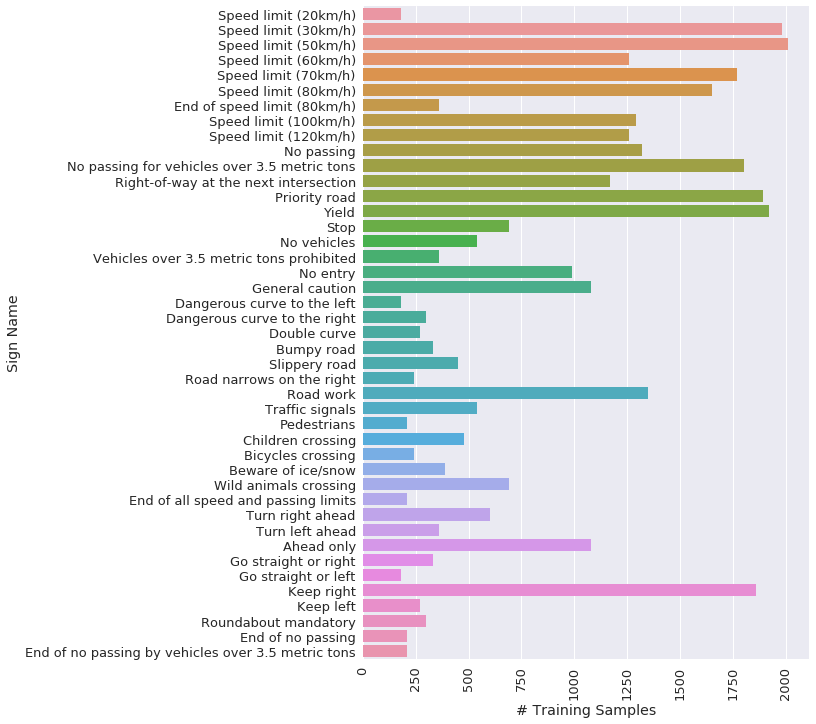

In [8]:
plt.figure(figsize=(8,12))
sns.set(font_scale=1.3)
sns.barplot(x='training_samples_count',y='sign',data=counts,orient='o')
plt.xticks(rotation=90)
plt.ylabel('Sign Name')
plt.xlabel('# Training Samples');
plt.savefig('plots/training_set_counts.png')


In [9]:
def get_random_samples(n_max=1):
    selected = list()
    
    for current_label in range(43):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1


    assert len(selected) ==  43*n_max
    return list(selected)

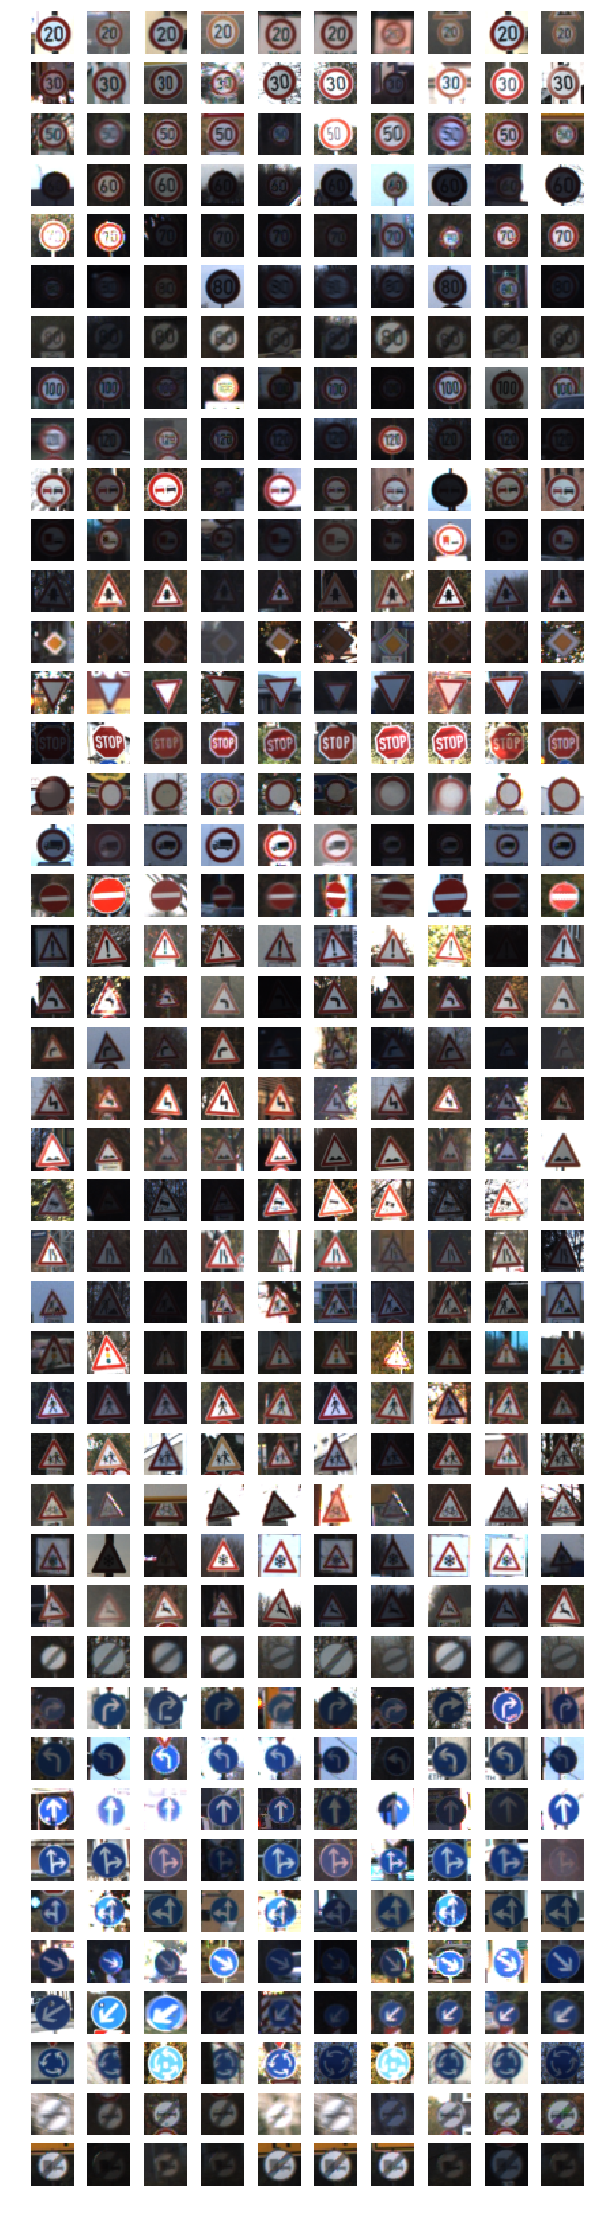

In [10]:
plt.figure(figsize=(10,40))
count=0
cols = 10
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(43,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.savefig('plots/random_examples.png')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a . It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [11]:
import cv2

Following the published baseline on this model we apply similar normalization and transformations. Images were transformed in the YUV space [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) and normalized with histogram normalization. Finally only the Y channel was selected. These transformations were applied in the transform_img function


In [12]:
img_size = 32

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def transform_img(img_in):
    img_in = img_in.copy()
    img_out= sharpen_img(img_in)
    img_out = cv2.cvtColor(img_in, cv2.COLOR_RGB2YUV)

    img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])
#     img_out[:,:,1] = cv2.equalizeHist(img_out[:,:,1])
#     img_out[:,:,2] = cv2.equalizeHist(img_out[:,:,2])
    
    return img_out[:,:,0]

def random_rotate_img(img):
    c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
    ang = 30.0*np.random.rand()-15
    Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
    return cv2.warpAffine(img, Mat, img.shape[:2])

def random_scale_img(img):
    img2=img.copy()
    sc_y=0.4*np.random.rand()+1.0
    img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
    
    dy = int((img2.shape[1]-img.shape[0])/2)
    end = img.shape[1]-dy
    img2 = img2[dy:end,:,:]
    assert img2.shape[0] == 32
#     print(img2.shape,dy,end)
    return img2

#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
    img2=cv2.multiply(img, np.array([s]))
    return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
    m=127.0*(1.0-s)
    return lin_img(img, s, m)


def augment_img(img):
    img = img.copy()
    img=contr_img(img, 1.8*np.random.rand()+0.2)
    img=random_rotate_img(img)
    img=random_scale_img(img)

    return transform_img(img)

(32, 32)


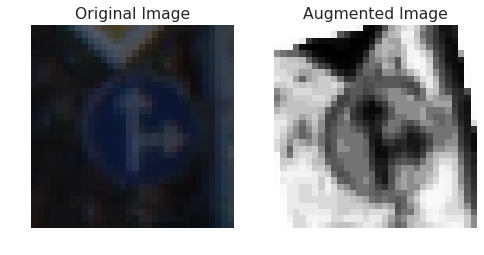

In [15]:
img = X_train[1000]
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
out = augment_img(img)
print(out.shape)
plt.imshow(out)
plt.title('Augmented Image')

plt.savefig('plots/augmented_img_example.png')


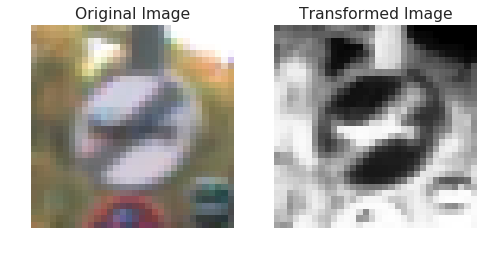

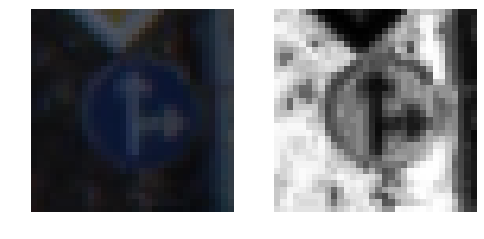

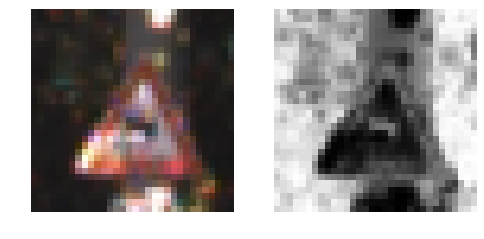

In [16]:
img = X_train[100]
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(transform_img(img))
plt.title('Transformed Image')

plt.figure()
img = X_train[1000]
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(transform_img(img))

plt.figure()
img = X_train[2190]
plt.subplot(1,2,1)
plt.imshow(img)

plt.axis('off')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(transform_img(img))

plt.savefig('plots/image_transformations.png')


In [17]:
# Transform all images and augment training datfa
X_train_transf = list()
y_train_transf = list()
X_test_transf = list()
X_valid_transf = list()
for ii in range(X_train.shape[0]):
    img = X_train[ii]
    label = y_train[ii]
    
    imgout = transform_img(img)
    imgout.shape = (1,) + imgout.shape + (1,)
    X_train_transf.append(imgout)
    y_train_transf.append(label)
    for j in range(5):
        imgout = augment_img(img)
        imgout.shape = (1,) + imgout.shape + (1,)
        X_train_transf.append(imgout)
        y_train_transf.append(label)
    

for ii in range(X_valid.shape[0]):
    img = X_valid[ii]
    img = transform_img(img)
    img.shape = (1,) + img.shape + (1,)
    X_valid_transf.append(img)
    
for ii in range(X_test.shape[0]):
    img = X_test[ii]
    img = transform_img(img)
    img.shape = (1,) + img.shape + (1,)
    X_test_transf.append(img)

X_test_transf = np.concatenate(X_test_transf,axis=0)
X_train_transf = np.concatenate(X_train_transf,axis=0)
X_valid_transf = np.concatenate(X_valid_transf,axis=0)
y_train_transf = np.array(y_train_transf)

### Model Architecture

In [18]:
import tensorflow as tf

In [19]:
from tensorflow.contrib.layers import flatten

def LeNet(x):
    """
    Implement classic lenet architecture in tensorflow
    """
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #  Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #  Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #  Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SFlatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #  Activation.
    fc1    = tf.nn.relu(fc1)
    
    dr1 = tf.nn.dropout(fc1, keep_prob) 
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(dr1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    
    
    dr2 = tf.nn.dropout(fc2, keep_prob) 
    
    #  Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(dr2, fc3_W) + fc3_b
    
    return logits

In [20]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [21]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
predict_operation = tf.argmax(logits, 1)
predict_proba_operation = tf.nn.softmax(logits=logits)

In [22]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


def predict(X_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    predicted_proba = list()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        predicted_proba.extend( sess.run(predict_proba_operation, feed_dict={x: batch_x, keep_prob: 1.0}))
        
        
    return predicted_proba


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [23]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [31]:
X_train = X_train_transf
X_valid = X_valid_transf
X_test = X_test_transf
y_train = y_train_transf

In [47]:
from sklearn.utils import shuffle
from time import time

In [ ]:
EPOCHS = 200
BATCH_SIZE = 128
dropout = .3

errors = list()

saver = tf.train.Saver()
start = time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        try:
            X_train, y_train = shuffle(X_train, y_train)
#             print("Before Train %d sec"%(time() - start))
            
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1 - dropout})
            
#             print("After Train %d sec"%(time() - start))
            
            validation_accuracy = evaluate(X_valid, y_valid)
            training_accuracy = evaluate(X_train, y_train)
            
            errors.append((training_accuracy,validation_accuracy))
            print("EPOCH %d - %d sec ..."%(i+1, time() - start))
            print("Training error = {:.3f} Validation error = {:.3f}".format(1- training_accuracy , 
                                                                                   1- validation_accuracy))
            
            print()
            
#             print("After error computation %d sec"%(time() - start))
            if i > 5 and i % 3 == 0:
                saver.save(sess, './models/lenet')
                print("Model saved %d sec"%(time() - start))
        except KeyboardInterrupt:
            break
    
    saver.save(sess, './models/lenet')

Training...

EPOCH 1 - 90 sec ...
Training error = 0.309 Validation error = 0.343

EPOCH 2 - 180 sec ...
Training error = 0.204 Validation error = 0.227

EPOCH 3 - 271 sec ...
Training error = 0.177 Validation error = 0.215

EPOCH 4 - 361 sec ...
Training error = 0.119 Validation error = 0.132



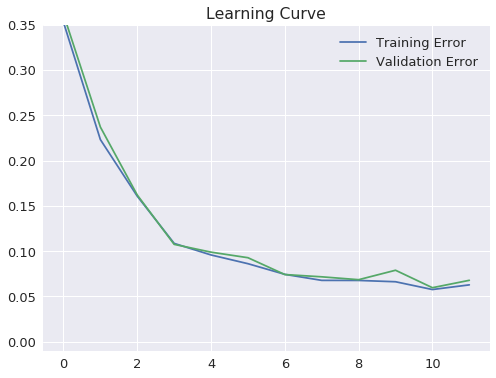

In [49]:
plt.figure(figsize=(8,6))
plt.title('Learning Curve')
plt.plot([1 - el[0] for el in errors])
plt.plot([1 - el[1] for el in errors])
plt.ylim([-.01,0.35])
plt.legend(['Training Error','Validation Error'])
plt.savefig('plots/learning_curve.png')


In [50]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    print('Accuracy Model On Test Images: {}'.format(evaluate(X_test,y_test)))   

Accuracy Model On Test Images: 0.9083927158599606


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [ ]:
import skimage
from skimage import io
from skimage import transform
from skimage.filters import gaussian
import glob

### Load and Output the Images

In [ ]:
i=1
plt.figure(figsize=(12,10))
for el in glob.glob('./images_signs/*.png') + glob.glob('./images_signs/*.jpg'):
    print(el)
    img = io.imread(el)    
#     img = transform.resize(img,(32,32), order=3)
#     img = gaussian(img,.4,multichannel=True)
    
    plt.subplot(1,6,i)
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
    img = transform.resize(img,(32,32), order=3)
    img = gaussian(img,.4,multichannel=True)
    
    

### Predict the Sign Type for Each Image

In [ ]:
# Read the images
i=1
images_wild = list()
labels_wild = list()
for line in open('images_signs/data.txt','r'):
    fname, label = line.strip().split(' ')
    label = int(label)
    fname = 'images_signs/'+fname
    img = io.imread(fname)    
    img = transform.resize(img,(32,32), order=3)
    img = gaussian(img,.4,multichannel=True)
    img.shape = (1,) + img.shape
    images_wild.append(img)
    labels_wild.append(label)
    

In [ ]:
images = np.concatenate(images_wild,axis=0)

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./models'))
    
    predicted_proba = np.vstack(predict(images))

    print('Accuracy Model On Internet Images: {}'.format(evaluate(images, labels_wild)))    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [ ]:
for true_label,row in zip(labels_wild,predicted_proba):
    top5k = np.argsort(row)[::-1][:5]
    top5p = np.sort(row)[::-1][:5]
    print('Top 5 Labels for image \'{}\':'.format(get_name_from_label(true_label)))
    for k,p in zip(top5k,top5p):
          print(' - \'{}\' with prob = {:.2f} '.format(get_name_from_label(k),p))

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
# with tf.Session() as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('./models'))
    
#     res = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#     conv2 = res[7]
    
#     outputFeatureMap(X_test[101:102,:], conv2, activation_min=-1, activation_max=-1 ,plt_num=1)

In [ ]:
xx = res[0]

In [ ]:
xx.name

outputFeatureMap(X_test[101:102,:],co

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 